In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib

# Load data
df = pd.read_csv("ncaa_data_all.csv")

df_features = df.drop(columns=["TeamID", "TeamName", "Ranking", "Quadrant"])
labels = df["Quadrant"] - 1
team_names = df["TeamName"]  # Save TeamName separately

# Split into train+val and test
X_temp, X_test, y_temp, y_test, idx_temp, idx_test = train_test_split(
    df_features, labels, df.index, test_size=0.2, stratify=labels, random_state=42
)

# Split train and validation
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_temp, y_temp, idx_temp, test_size=0.2, stratify=y_temp, random_state=42
)

# Save to joblib
joblib.dump({
    "X_train": X_train,
    "X_val": X_val,
    "X_test": X_test,
    "y_train": y_train,
    "y_val": y_val,
    "y_test": y_test,
    "idx_test": idx_test,
    "team_names": team_names
}, "ncaa_rf_svm_data_splits.joblib")

print("✅ Data splits saved to ncaa_rf_svm_data_splits.joblib")


✅ Data splits saved to ncaa_rf_svm_data_splits.joblib


Train Loss: 0.2156, Val Loss: 0.9746, Test F1 Score: 0.5916


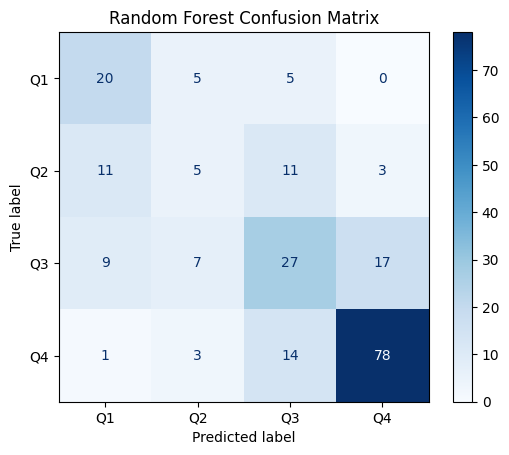

In [6]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, log_loss

# Load data splits
data = joblib.load("ncaa_rf_svm_data_splits.joblib")
X_train, X_val, X_test = data["X_train"], data["X_val"], data["X_test"]
y_train, y_val, y_test = data["y_train"], data["y_val"], data["y_test"]
idx_test = data["idx_test"]
team_names = data["team_names"]

# Train model
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

# Evaluate performance
train_proba = rf.predict_proba(X_train)
val_proba = rf.predict_proba(X_val)
test_proba = rf.predict_proba(X_test)
test_pred = np.argmax(test_proba, axis=1)

train_loss = log_loss(y_train, train_proba)
val_loss = log_loss(y_val, val_proba)
f1 = f1_score(y_test, test_pred, average='weighted')

print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Q1", "Q2", "Q3", "Q4"])
disp.plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

# Save model and predictions
joblib.dump(rf, "best_model_RandomForest.joblib")

# Save results with team names and probabilities
test_team_names = team_names.iloc[idx_test].reset_index(drop=True)
results_df = pd.DataFrame(test_proba, columns=["P_Q1", "P_Q2", "P_Q3", "P_Q4"])
results_df["TeamName"] = test_team_names
results_df["True_Label"] = [f"Q{label+1}" for label in y_test]
results_df["Pred_Label"] = [f"Q{pred+1}" for pred in test_pred]
results_df = results_df[["TeamName", "True_Label", "Pred_Label", "P_Q1", "P_Q2", "P_Q3", "P_Q4"]]
results_df.to_csv("rf_test_predictions.csv", index=False)

Train Loss: 0.9409, Val Loss: 1.0552, Test F1 Score: 0.5193


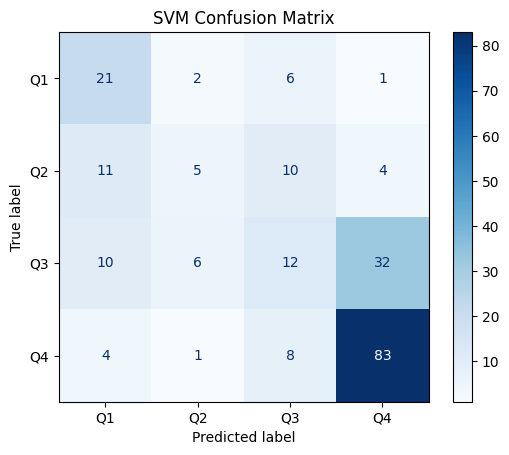

In [7]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, log_loss

# Load data splits
data = joblib.load("ncaa_rf_svm_data_splits.joblib")
X_train, X_val, X_test = data["X_train"], data["X_val"], data["X_test"]
y_train, y_val, y_test = data["y_train"], data["y_val"], data["y_test"]
idx_test = data["idx_test"]
team_names = data["team_names"]

# Train model
svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)

# Evaluate performance
train_proba = svm.predict_proba(X_train)
val_proba = svm.predict_proba(X_val)
test_proba = svm.predict_proba(X_test)
test_pred = np.argmax(test_proba, axis=1)

train_loss = log_loss(y_train, train_proba)
val_loss = log_loss(y_val, val_proba)
f1 = f1_score(y_test, test_pred, average='weighted')

print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Q1", "Q2", "Q3", "Q4"])
disp.plot(cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.show()

# Save model and predictions
joblib.dump(svm, "best_model_SVM.joblib")

# Save results with team names and probabilities
test_team_names = team_names.iloc[idx_test].reset_index(drop=True)
results_df = pd.DataFrame(test_proba, columns=["P_Q1", "P_Q2", "P_Q3", "P_Q4"])
results_df["TeamName"] = test_team_names
results_df["True_Label"] = [f"Q{label+1}" for label in y_test]
results_df["Pred_Label"] = [f"Q{pred+1}" for pred in test_pred]
results_df = results_df[["TeamName", "True_Label", "Pred_Label", "P_Q1", "P_Q2", "P_Q3", "P_Q4"]]
results_df.to_csv("svm_test_predictions.csv", index=False)